In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [0]:
dataset1 = pd.read_csv("/content/drive/My Drive/LoanStats_securev1_2018Q1.csv", skiprows = 1, low_memory= False)
dataset2 = pd.read_csv("/content/drive/My Drive/LoanStats_securev1_2018Q2.csv", skiprows = 1, low_memory= False)
dataset3 = pd.read_csv("/content/drive/My Drive/LoanStats_securev1_2018Q3.csv", skiprows = 1, low_memory= False)
dataset4 = pd.read_csv("/content/drive/My Drive/LoanStats_securev1_2018Q4.csv", skiprows = 1, low_memory= False)

In [0]:
dataset1.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,...,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,107864.000000,107864.000000,107864.000000,107864.000000,1.078640e+05,0.0,107602.000000,107864.000000,107864.000000,107864.000000,107864.000000,47169.000000,15269.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,24761.000000,107864.0,1.633100e+04,16331.000000,107864.000000,1.078640e+05,1.078640e+05,107864.000000,107864.000000,...,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,107864.000000,104356.0,107864.000000,107864.000000,107864.000000,107863.000000,106350.000000,107864.000000,107864.000000,1.078640e+05,1.078640e+05,107864.000000,107864.000000,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000,16021.000000,16331.000000,16331.000000,16331.000000,16331.000000,5427.000000,496.0,496.000000,496.0,496.000000,372.00000,496.000000,496.000000,922.000000,922.000000,922.000000
mean,NaN,16147.942780,16147.942780,16143.858212,469.643135,7.854227e+04,NaN,19.648209,0.223773,708.248303,712.248702,0.461266,36.980008,79.156657,11.377151,0.163243,16093.382880,22.618019,6470.917022,6469.595226,10858.427748,10855.413980,8537.115682,2229.953775,1.592056,89.766237,16.062249,3269.428852,700.830852,690.644562,0.016734,46.193167,1.0,1.255066e+05,19.661708,0.000241,2.932763e+02,1.437632e+05,0.904936,2.655613,...,7.198277,8.049117,8.064989,12.970871,5.214446,11.351915,0.0,0.000213,0.058333,2.001836,94.662365,32.454015,0.123971,0.039160,1.852063e+05,5.093050e+04,26957.654806,45064.532587,34531.574919,668.621334,672.621334,0.647174,1.550915,11.624150,58.675382,3.011573,12.770375,0.057314,0.080583,35.498987,3.0,188.513952,3.0,14.447581,575.98629,14651.592258,211.767137,6729.599902,50.906128,18.257050
std,NaN,10184.024938,10184.024938,10182.885624,289.214551,7.687436e+04,NaN,21.795902,0.730417,37.205453,37.206924,0.746153,21.802486,24.817082,5.879388,0.494799,22176.260283,12.027177,7496.391005,7495.817046,8159.772528,8158.125057,7544.474890,2024.906391,12.430434,563.338451,101.055152,6509.677424,68.455160,101.029745,0.142971,21.555390,0.0,6.681665e+04,8.038172,0.015524,2.481319e+04,1.676133e+05,1.122125,2.930210,...,4.569414,7.264086,4.880940,7.885984,3.307535,5.870785,0.0,0.014601,0.401722,1.861591,9.036803,34.897087,0.335350,0.352788,1.886676e+05,5.190748e+04,25827.858576,47269.256578,28087.749846,46.698394,46.698394,1.021778,1.788622,6.665203,25.927238,3.248730,8.287120,0.455782,0.437520,23.915029,0.0,139.792382,0.0,8.187529,429.21545,8606.498544,189.311806,4511.2

In [0]:
dataset = pd.concat([dataset1,dataset2,dataset3,dataset4])
dataset.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,...,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,495242.000000,495242.000000,495242.000000,495242.000000,4.952420e+05,0.0,494110.000000,495242.000000,495242.000000,495242.000000,495242.000000,218590.000000,62984.000000,495242.000000,495242.000000,4.952420e+05,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.00000,114833.000000,495242.0,6.898500e+04,68985.000000,495242.000000,4.952420e+05,4.952420e+05,495242.000000,495242.000000,...,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,482838.0,495242.000000,495242.000000,495242.000000,495240.000000,488646.000000,495242.000000,495242.000000,4.952420e+05,4.952420e+05,4.952420e+05,4.952420e+05,6.898500e+04,68985.000000,68985.000000,68985.000000,68985.000000,68985.000000,67788.000000,68985.000000,68985.000000,68985.000000,68985.000000,22377.000000,1260.0,1260.000000,1260.0,1260.000000,1002.000000,1260.000000,1260.000000,2311.000000,2311.000000,2311.000000
mean,NaN,16025.020394,16025.020394,16021.669323,466.604563,8.009399e+04,NaN,19.668887,0.229252,706.403637,710.403974,0.442192,36.889771,83.338689,11.491554,0.134514,1.627083e+04,22.624151,8741.260158,8739.717289,8456.051492,8454.026230,6537.246223,1870.217347,1.105113,47.482812,8.482601,2550.963930,702.167169,693.698242,0.01768,46.319281,1.0,1.283419e+05,19.357812,0.000052,2.143619e+02,1.439598e+05,0.898078,2.700815,...,7.092944,8.169146,8.163348,12.918500,5.324668,11.470647,0.0,0.000046,0.059932,2.030478,94.580900,32.891971,0.123489,0.010918,1.849417e+05,5.192192e+04,2.667946e+04,4.568810e+04,3.475705e+04,671.835471,675.835486,0.607538,1.538189,11.486497,57.108528,2.998043,12.517707,0.041748,0.070943,37.326183,3.0,199.842325,3.0,14.265873,601.684371,15416.917786,218.088048,6960.379792,51.097508,18.605366
std,NaN,10138.075023,10138.075023,10137.900360,286.907222,8.887161e+04,NaN,20.458244,0.743665,36.045280,36.046582,0.724613,21.777614,23.067742,5.947129,0.384829,2.283236e+04,12.104004,8549.574347,8549.306378,7258.227402,7257.169152,6747.708690,1681.844843,9.706950,416.134505,74.585035,5826.128193,62.473851,88.942759,0.14657,21.603329,0.0,8.432331e+04,8.089185,0.007245,1.166300e+04,1.674899e+05,1.121055,2.930219,...,4.520551,7.353481,4.936628,7.896373,3.366916,5.941238,0.0,0.006815,0.420412,1.890030,9.092862,35.015405,0.335296,0.182740,1.886940e+05,5.339667e+04,2.582489e+04,4.797206e+04,2.959911e+04,44.853131,44.853187,0.969398,1.766506,6.670732,25.836450,3.236424,8.211074,0.390470,0.393264,23.803320,0.0,143.467665,0.0,8.063387,426.917088,8875.449155,200.476205,47

In [0]:
dataset.shape

(495250, 150)

In [0]:
# Drop duplicated if there are any.
dataset.duplicated().sum()

0

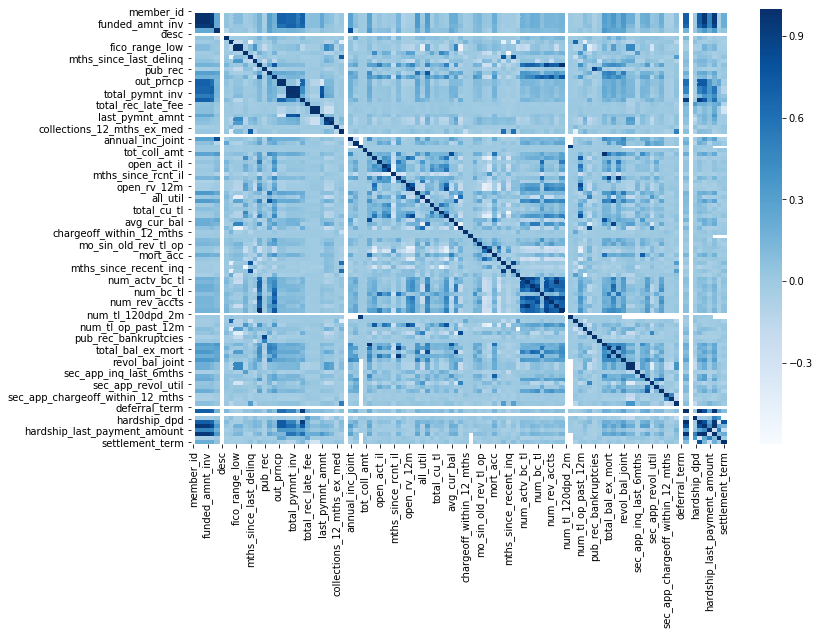

In [0]:
sns.heatmap(dataset.corr(),cmap='Blues',annot=False) 

## Decide on a Target Column

Our main goal is to predict who will pay off a loan and who will default, so we need to find a column that reflects this. We learned from the description of columns in the preview DataFrame that loan_status is the only field in the main data set that describes a loan status, so let’s use this column as the target column.

In [0]:
meaning = [
"Loan is up to date on current payments.",
"Loan has been fully paid off.",
"Loan for which there is no longer a reasonable expectation of further payments.",
"Loan hasn't been paid in 31 to 120 days (late on the current payment).",
"The loan is past due but still in the grace period of 15 days.",
"Loan hasn't been paid in 16 to 30 days (late on the current payment).",
"Loan is defaulted on and no payment has been made for more than 121 days."]
status, count = dataset["loan_status"].value_counts().index, dataset["loan_status"].value_counts().values
loan_statuses_explanation = pd.DataFrame({'Loan Status': status,'Count': count,'Meaning': meaning})
loan_statuses_explanation

,Loan Status,Count,Meaning
0,Current,356785,Loan is up to date on current payments.
1,Fully Paid,97392,Loan has been fully paid off.
2,Charged Off,24178,Loan for which there is no longer a reasonable...
3,Late (31-120 days),10328,Loan hasn't been paid in 31 to 120 days (late ...
4,In Grace Period,3055,The loan is past due but still in the grace pe...
5,Late (16-30 days),2675,Loan hasn't been paid in 16 to 30 days (late o...
6,Default,829,Loan is defaulted on and no payment has been m...


We have the following conclusion after analyzing the table above:

1. Only "Fully Paid" and "Charge Off" describe the final outcome of a loan. 

2. The other values describe ongoing loans.

Our goal is to build a machine learning model that can learn from past loans in trying to predict which loans will be paid off. This means we’re interested in being able to predict which of 'Fully Paid' or 'Charged Off' a loan will fall under, so we can treat the problem as binary classification. 

Therefore, we are going to remove all other columns other than 'Fully Paid' or 'Charged Off'.

In [0]:
dataset = dataset[(dataset["loan_status"] == "Fully Paid")|(dataset["loan_status"] == "Charged Off")]
mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
dataset = dataset.replace(mapping_dictionary)

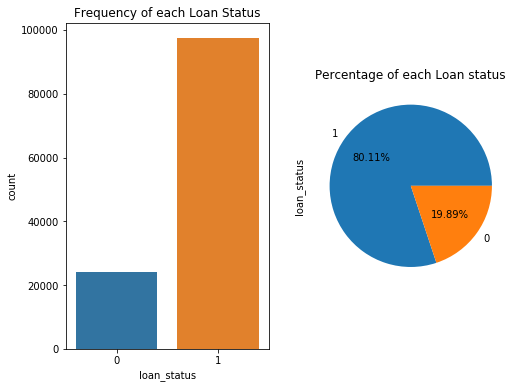

After filtering the loans dataset, the shape of data is (121570, 150)


In [0]:
#visualizing the target column outcomes
fig, axs = plt.subplots(1,2,figsize=(8,6))
sns.countplot(x='loan_status',data=dataset,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
dataset.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()
print("After filtering the loans dataset, the shape of data is {}".format(dataset.shape))

## Data Cleaning


### Manual Feature Engineering: Remove Unrelevant Features or that Leak Future Info

Recall a column is considered to leak information when the data it contains won’t be available when we use our model to make predictions. Data leakage would cause the model to overfit.

Here, we hope to drop some columns are not useful for our purposes. Here, we found the following columns that: 1) contain redundant information,  and 2) are likely to leak data from the future:

1. desc - contains text explanation for a loan.
2. url - contains a link to each loan from Lending Club
3. id — randomly generated field by LendingClub for unique identification purposes only.
4. member_id — also randomly generated field by LendingClub for identification purposes only.
5. funded_amnt — leaks information from the future (after the loan is already started to be funded).
6. funded_amnt_inv — also leaks data from the future.
7. sub_grade — contains redundant information that is already in the grade column (more below).
8. int_rate — also included within the grade column.
9. emp_title — requires other data and a lot of processing to become potentially useful
10. issued_d — leaks data from the future.
11. zip_code – mostly redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible. If all digits are available, we could probably use this feature.
12. out_prncp – leaks data from the future.
13. out_prncp_inv – also leaks data from the future.
14. total_pymnt – also leaks data from the future.
15. total_pymnt_inv – also leaks data from the future.
16. total_rec_prncp - also leaks data from the future.
17. total_rec_int - also leaks data from the future.
18. total_rec_late_fee - also leaks data from the future.
19. recoveries - also leaks data from the future.
20. collection_recovery_fee - also leaks data from the future.
21. last_pymnt_d - also leaks data from the future.
22. last_pymnt_amnt - also leaks data from the future.
23. last_fico_range_low - also leaks data from the future.
24. last_fico_range_high - also leaks data from the future.

The following features concerning hardship or settlement all leak data from the future. 

25. hardship_flag
26. hardship_type
27. hardship_reason
28. hardship_status
29. deferral_term
30. hardship_amount
31. hardship_start_date
32. hardship_end_date
33. payment_plan_start_date
34. hardship_length
35. hardship_dpd
36. hardship_loan_status
37. orig_projected_additional_accrued_interest
38. hardship_payoff_balance_amount
39. hardship_last_payment_amount
40. disbursement_method
41. debt_settlement_flag
42. debt_settlement_flag_date
43. settlement_status
44. settlement_date
45. settlement_amount
46. settlement_percentage
47. settlement_term


In [0]:
drop_list1 = ['desc','url','id','member_id','funded_amnt','funded_amnt_inv',
'int_rate','sub_grade','emp_title','issue_d', 'zip_code','out_prncp','out_prncp_inv',
'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int', 
'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
'last_fico_range_low', 'last_fico_range_high']
drop_list2 = str("hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term").split(",")
drop_list = drop_list1+drop_list2
loans_ = dataset.drop(drop_list, axis = 1)
print("After manually removing {} feautres, the loans dataset now has {} rows and {} columns.".format(len(drop_list), loans_.shape[0], loans_.shape[1]))

After manually removing 46 feautres, the loans dataset now has 121570 rows and 104 columns.


### Manual Feature Engineering: Remove Redundant Secondary Applicant Features
The features below contain information regarding the secondary applicant

1.   sec_app_fico_range_low: FICO range (high) for the secondary applicant
2.   sec_app_fico_range_high: FICO range (low) for the secondary applicant
3. sec_app_earliest_cr_line: Earliest credit line at time of application for the secondary applicant
4. sec_app_inq_last_6mths: Credit inquiries in the last 6 months at time of application for the secondary applicant
5. sec_app_mort_acc: Number of mortgage accounts at time of application for the secondary applicant
6. sec_app_open_acc: Number of open trades at time of application for the secondary applicant
7. sec_app_revol_util: Ratio of total current balance to high credit/credit limit for all revolving accounts
8. sec_app_open_act_il: Number of currently active installment trades at time of application for the secondary applicant
9. sec_app_num_rev_accts: Number of revolving accounts at time of application for the secondary applicant
10. sec_app_chargeoff_within_12_mths: Number of charge-offs within last 12 months at time of application for the secondary applicant
11. sec_app_collections_12_mths_ex_med: Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant
12. sec_app_mths_since_last_major_derog: Months since most recent 90-day or worse rating at time of application for the secondary applicant

We first explore their relationship with corresponding primary applicant features:
13. fico_range_high
14. fico_range_low
15. earliest_cr_line
16. inq_last_6mnths
17. mort_acc
18. open_acc
19. revol_util
20. open_act_il
21. num_rev_accts
22. chargeoff_within_12_mths
23. collections_12_mths_ex_med
24. mths_since_last_major_derog

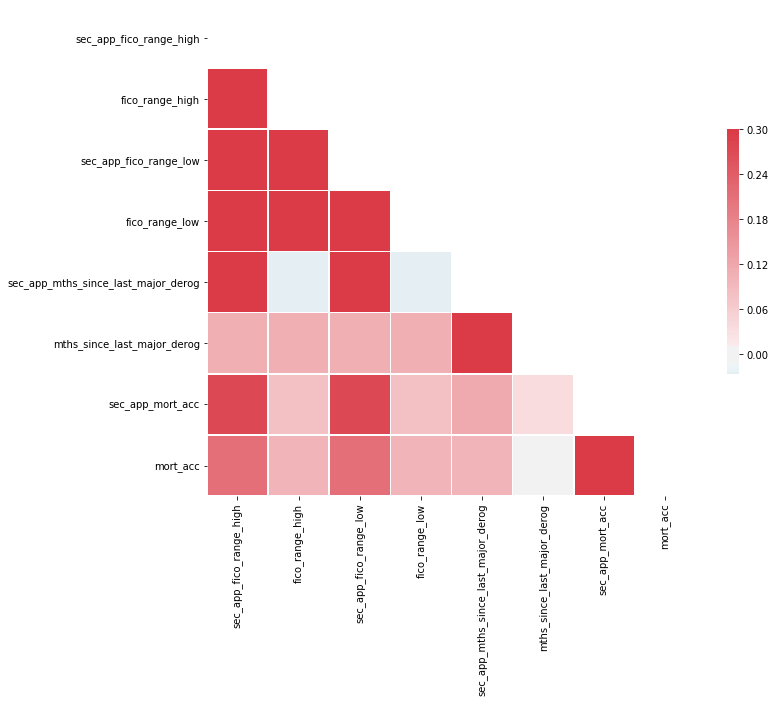

In [0]:
columns1 = ['sec_app_fico_range_high', 'fico_range_high','sec_app_fico_range_low','fico_range_low','sec_app_mths_since_last_major_derog','mths_since_last_major_derog','sec_app_mort_acc','mort_acc' ]
corr1 = loans_.loc[:,columns1].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(1, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#sns.heatmap(corr1, xticklabels=corr1.columns,yticklabels=corr1.columns)

From the selected 4 pairs of features, we notice that the features of secondary applicant are highly correlated with the corresponding features of primary applicant.

In [0]:
sec_columns = ['sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog']
loans_[sec_columns].isnull().sum()

sec_app_fico_range_low                 105928
sec_app_fico_range_high                105928
sec_app_earliest_cr_line               105928
sec_app_inq_last_6mths                 105928
sec_app_mort_acc                       105928
sec_app_open_acc                       105928
sec_app_revol_util                     106202
sec_app_open_act_il                    105928
sec_app_num_rev_accts                  105928
sec_app_chargeoff_within_12_mths       105928
sec_app_collections_12_mths_ex_med     105928
sec_app_mths_since_last_major_derog    116224
dtype: int64

Moreover, the value of secondary applicant features are mostly N/A. It is resonable because the value is only available for users who apply for joint loan. Therefore we can drop all features of secondary applicant.

In [0]:
loans_ = loans_.drop(sec_columns, axis = 1)
print("After manually removing {} feautres, the loans dataset now has {} rows and {} columns.".format(len(sec_columns), loans_.shape[0], loans_.shape[1]))

After manually removing 12 feautres, the loans dataset now has 121570 rows and 92 columns.


### Manual Feature Engineering: Composite a New Feature: Avergae FICO score

When a borrower applies for a loan, LendingClub gets the borrower’s credit score from FICO — they are given a lower and upper limit of the range that the borrowers score belongs to, and they store those values as "fico_range_low", "fico_range_high". After that, any updates to the borrowers score are recorded as "last_fico_range_low", and "last_fico_range_high". 

These two columns have been removed in previous steps. Because FICO scores continue to be updated by LendingClub after a loan is funded. In other words, while we can use the initial FICO scores (fico_range_low and fico_range_high) — those would be available as part of a borrower’s applicaton — we cannot use last_fico_range_low, and last_fico_range_high, as LendingClub may have updated these after the borrower’s application. 

Hence, here we only need to focus on the rest two columns: "fico_range_high" and "fico_range_low". To better capture the overall credit score evaluation of a borrower, we create "fico_average", which is the average of "fico_range_low" and "fico_range_high".

In [0]:
print(loans_["fico_range_low"].unique())
print(loans_["fico_range_high"].unique())
#print(loans_["sec_app_fico_range_low"].unique())
#print(loans_["sec_app_fico_range_high"].unique())

[735. 795. 695. 700. 720. 730. 665. 690. 660. 705. 675. 680. 760. 765.
 710. 725. 670. 685. 780. 755. 800. 770. 745. 715. 790. 775. 750. 740.
 785. 805. 810. 835. 815. 830. 825. 820. 840. 845.]
[739. 799. 699. 704. 724. 734. 669. 694. 664. 709. 679. 684. 764. 769.
 714. 729. 674. 689. 784. 759. 804. 774. 749. 719. 794. 779. 754. 744.
 789. 809. 814. 839. 819. 834. 829. 824. 844. 850.]


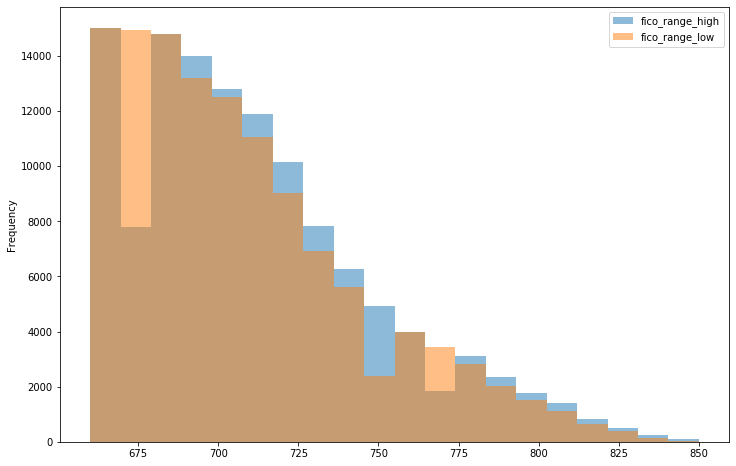

In [0]:
# remove missing records in these two columns.
fico_columns = ['fico_range_high','fico_range_low']
# # loans__ = loans_.dropna(subset = fico_columns)
# print("The shape of the dataset turned from {} to {}".format(loans_.shape, loans_.shape))
loans_[fico_columns].plot.hist(alpha=0.5,bins=20)

In [0]:
loans__ = loans_

# Create average column
loans__['fico_average'] = (loans__['fico_range_high'] + loans__['fico_range_low']) / 2 
#loans__['sec_app_fico_average'] = (loans__['sec_app_fico_range_high'] + loans__['sec_app_fico_range_low']) / 2 
fico_columns_ = ['fico_range_low','fico_range_high','fico_average']
loans__[fico_columns_].head()

,fico_range_low,fico_range_high,fico_average
3,735.0,739.0,737.0
8,795.0,799.0,797.0
18,695.0,699.0,697.0
21,700.0,704.0,702.0
24,720.0,724.0,722.0


In [0]:
# drop "fico_range_low", "fico_range_high", "sec_app_fico_range_low", "sec_app_fico_range_high".
loans___ = loans__.drop(fico_columns, axis = 1)
print("The shape of the loans dataset is now {}".format(loans___.shape))

The shape of the loans dataset is now (121570, 91)


###Investigate Missing Values

In [0]:
loans___.shape[0]*0.01

1215.7

Lets remove the columns entirely if more than 1%  (1215) of the rows have missing value for that column.

In [0]:
drop_na = []
count_na = loans___.isnull().sum(axis = 0).to_dict()
for k,v in count_na.items():
  if v > 1215:
    print(k,v)
    drop_na.append(k)

emp_length 10497
mths_since_last_delinq 66768
mths_since_last_record 103439
next_pymnt_d 121570
mths_since_last_major_derog 91757
annual_inc_joint 105928
dti_joint 105928
verification_status_joint 106583
mths_since_rcnt_il 4066
il_util 19464
bc_open_to_buy 1913
bc_util 1993
mo_sin_old_il_acct 4066
mths_since_recent_bc 1784
mths_since_recent_bc_dlq 96452
mths_since_recent_inq 10753
mths_since_recent_revol_delinq 85497
num_tl_120dpd_2m 3260
percent_bc_gt_75 1915
revol_bal_joint 105928


In [0]:
loans___ = loans___.drop(drop_na, axis=1)
print("Now we have {} columns.".format(loans___.shape[1]))

Now we have 71 columns.


### Drop Columns with Only One Value

To wrap up this section, let’s look for any columns that contain only one unique value and remove them. These columns won’t be useful for the model since they don’t add any information to each loan application. In addition, removing these columns will reduce the number of columns we’ll need to explore further in the next stage.



Firstly, remove columns with only one unique values

In [0]:
loans___ = loans___.loc[:,loans___.apply(pd.Series.nunique) != 1]
print("Now we have {} columns.".format(loans___.shape[1]))

Now we have 69 columns.


Again, there may be some columns with more than one unique value, but one value that has insignificant frequency in the data set. Let’s find and drop any columns with unique values that appear fewer than four times:

In [0]:
for col in loans___.columns:
    if (len(loans___[col].unique()) < 4):
      print(loans___[col].value_counts())

 36 months    89598
 60 months    31972
Name: term, dtype: int64
Source Verified    48722
Not Verified       46541
Verified           26307
Name: verification_status, dtype: int64
1    97392
0    24178
Name: loan_status, dtype: int64
w    102139
f     19431
Name: initial_list_status, dtype: int64
Individual    105928
Joint App      15642
Name: application_type, dtype: int64
0.0    121561
1.0         9
Name: acc_now_delinq, dtype: int64
0.0    121561
1.0         9
Name: num_tl_30dpd, dtype: int64


The feature "acc_now_delinq" and "num_tl_30dpd" only have 9 unique values "1". It is not informative. We can drop these two features.

In [0]:
loans___ = loans___.drop(["acc_now_delinq","num_tl_30dpd"], axis=1)
print("Now we have {} columns.".format(loans___.shape[1]))

Now we have 67 columns.


In [0]:
loans___.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'application_type', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m',
       'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_r

### Investigate Highly Correlated Features


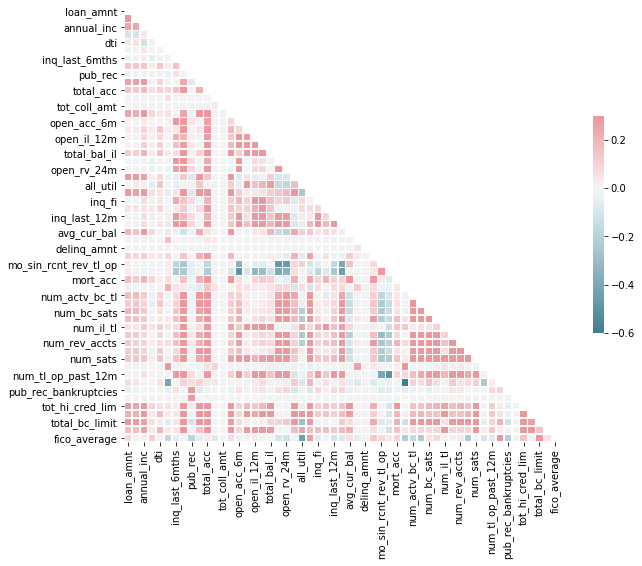

In [0]:
corr2 = loans___.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
corr2 = corr2.abs()
# Select upper triangle of correlation matrix
upper = corr2.where(np.triu(np.ones(corr2.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

In [0]:
to_drop

['installment',
 'open_il_24m',
 'open_rv_24m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_op_past_12m',
 'pub_rec_bankruptcies',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

In [0]:
loans___ = loans___.drop(to_drop, axis=1)
print("Now we have {} columns.".format(loans___.shape[1]))

Now we have 49 columns.


### Investigate Numerical and Categorical Features

In [0]:
loans_dict = {}
for col in loans___.columns:
  loans_dict[col] = loans___[col].unique()
cols_categorical = []
cols_numerical = []
for col in loans_dict:
  if type(loans_dict[col][-1]) == type("str"):
    cols_categorical.append(col)
  else:
    cols_numerical.append(col)
print('categorical columns:')
print(cols_categorical)
print('altogether {} cols'.format(len(cols_categorical)))

print('numerical columns:')
print(cols_numerical)
print('altogether {} cols'.format(len(cols_numerical)))


categorical columns:
['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'title', 'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status', 'application_type']
altogether 11 cols
numerical columns:
['loan_amnt', 'annual_inc', 'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'total_bal_il', 'open_rv_12m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_il_tl', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'tax_liens', 'fico_average']
altogether 38 cols


In [0]:
loans___.head()

,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,application_type,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,tax_liens,fico_average
3,12500.0,36 months,A,MORTGAGE,110000.0,Not Verified,1,credit_card,Credit card refinancing,PA,14.10,0.0,Sep-2005,1.0,11.0,0.0,10237.0,30%,21.0,w,Jul-2019,0.0,Individual,0.0,350848.0,1.0,2.0,2.0,41683.0,1.0,5369.0,64.0,34100.0,2.0,0.0,7.0,0.0,0.0,90.0,10.0,5.0,4.0,1.0,3.0,10.0,0.0,95.2,0.0,737.0
8,20000.0,36 months,B,MORTGAGE,19000.0,Verified,1,debt_consolidation,Debt consolidation,FL,45.17,0.0,Oct-1987,1.0,6.0,0.0,17144.0,33.4%,9.0,w,Oct-2019,0.0,Joint App,0.0,17709.0,1.0,1.0,0.0,565.0,1.0,6776.0,24.0,41300.0,0.0,0.0,1.0,0.0,0.0,365.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,100.0,0.0,797.0
18,7000.0,36 months,B,MORTGAGE,40000.0,Verified,1,home_improvement,Home improvement,TX,20.25,0.0,Mar-2007,0.0,13.0,0.0,5004.0,36%,29.0,w,Oct-2019,0.0,Individual,0.0,131726.0,1.0,6.0,0.0,126722.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,0.0,0.0,132.0,1.0,1.0,0.0,3.0,2.0,19.0,0.0,89.7,0.0,697.0
21,10000.0,36 months,B,RENT,52320.0,Source Verified,1,debt_consolidation,Debt consolidation,WA,12.87,0.0,Oct-2007,1.0,6.0,1.0,1692.0,38.5%,26.0,w,Oct-2019,0.0,Individual,0.0,74220.0,0.0,3.0,2.0,72528.0,1.0,1692.0,94.0,4400.0,2.0,1.0,4.0,0.0,0.0,48.0,7.0,7.0,0.0,0.0,1.0,23.0,0.0,100.0,0.0,702.0
24,28000.0,36 months,B,MORTGAGE,103000.0,Source Verified,1,debt_consolidation,Debt consolidation,NC,30.76,0.0,Mar-2002,0.0,12.0,0.0,21266.0,26.5%,30.0,w,May-2019,0.0,Individual,0.0,76475.0,3.0,3.0,2.0,55209.0,1.0,10750.0,41.0,80300.0,0.0,0.0,0.0,0.0,0.0,184.0,2.0,2.0,1.0,1.0,4.0,12.0,0.0,96.7,0.0,722.0


We noticed that there are 2 features being misclassified: revol_util in percentage should be a numerical feature and "last_credit_pull_d" should be a categorical feature.

In [0]:
loans___['revol_util'][:3]

3       30%
8     33.4%
18      36%
Name: revol_util, dtype: object

In [0]:
loans___['revol_util']= loans___['revol_util'].str.rstrip('%').astype('float') / 100.0

In [0]:
loans___['revol_util'][:5]

3     0.300
8     0.334
18    0.360
21    0.385
24    0.265
Name: revol_util, dtype: float64

In [0]:
cols_numerical.remove("last_credit_pull_d")
cols_categorical.append("last_credit_pull_d")
cols_categorical.remove('revol_util')
cols_numerical.append('revol_util')


###### Imputation of Missing Values

Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. For simplicity reasons, we choose to replace all missing values with mean of each numerical columns, and use the most common values for categorical features.

First, we need to separate categorical columns with numerical columns

Second, we deal with missing value in numerical features.

Third, we deal with missing values in categorical features.

In the next step, we will focus on encoding categorical features.









#### Deal with Numerical Data

In [0]:
loans_nume = loans___[cols_numerical]

In [0]:
loans_nume.head()

,loan_amnt,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,tax_liens,fico_average,revol_util
3,12500.0,110000.0,1,14.10,0.0,1.0,11.0,0.0,10237.0,21.0,0.0,0.0,350848.0,1.0,2.0,2.0,41683.0,1.0,5369.0,64.0,34100.0,2.0,0.0,7.0,0.0,0.0,90.0,10.0,5.0,4.0,1.0,3.0,10.0,0.0,95.2,0.0,737.0,0.300
8,20000.0,19000.0,1,45.17,0.0,1.0,6.0,0.0,17144.0,9.0,0.0,0.0,17709.0,1.0,1.0,0.0,565.0,1.0,6776.0,24.0,41300.0,0.0,0.0,1.0,0.0,0.0,365.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,100.0,0.0,797.0,0.334
18,7000.0,40000.0,1,20.25,0.0,0.0,13.0,0.0,5004.0,29.0,0.0,0.0,131726.0,1.0,6.0,0.0,126722.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,0.0,0.0,132.0,1.0,1.0,0.0,3.0,2.0,19.0,0.0,89.7,0.0,697.0,0.360
21,10000.0,52320.0,1,12.87,0.0,1.0,6.0,1.0,1692.0,26.0,0.0,0.0,74220.0,0.0,3.0,2.0,72528.0,1.0,1692.0,94.0,4400.0,2.0,1.0,4.0,0.0,0.0,48.0,7.0,7.0,0.0,0.0,1.0,23.0,0.0,100.0,0.0,702.0,0.385
24,28000.0,103000.0,1,30.76,0.0,0.0,12.0,0.0,21266.0,30.0,0.0,0.0,76475.0,3.0,3.0,2.0,55209.0,1.0,10750.0,41.0,80300.0,0.0,0.0,0.0,0.0,0.0,184.0,2.0,2.0,1.0,1.0,4.0,12.0,0.0,96.7,0.0,722.0,0.265


Replacing missing value with mean

In [0]:
from sklearn.impute import SimpleImputer, MissingIndicator
imp1 = SimpleImputer(missing_values=np.nan, strategy='mean')
loans_nume__ = imp1.fit_transform(loans_nume)
loans_nume_ = pd.DataFrame(loans_nume__, columns = cols_numerical, index = None)

print(loans_nume_.describe())

           loan_amnt    annual_inc  ...   fico_average     revol_util
count  121570.000000  1.215700e+05  ...  121570.000000  121570.000000
mean    15111.814181  7.903141e+04  ...     709.261208       0.403886
std      9984.015994  7.457124e+04  ...      37.208481       0.252933
min      1000.000000  0.000000e+00  ...     662.000000       0.000000
25%      7281.250000  4.620250e+04  ...     682.000000       0.199000
50%     12000.000000  6.600000e+04  ...     702.000000       0.377000
75%     20000.000000  9.500000e+04  ...     732.000000       0.588000
max     40000.000000  9.300000e+06  ...     847.500000       1.463000

[8 rows x 38 columns]


In [0]:
#check the numerical cols:
loans_nume_.head()

,loan_amnt,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,tax_liens,fico_average,revol_util
0,12500.0,110000.0,1.0,14.10,0.0,1.0,11.0,0.0,10237.0,21.0,0.0,0.0,350848.0,1.0,2.0,2.0,41683.0,1.0,5369.0,64.0,34100.0,2.0,0.0,7.0,0.0,0.0,90.0,10.0,5.0,4.0,1.0,3.0,10.0,0.0,95.2,0.0,737.0,0.300
1,20000.0,19000.0,1.0,45.17,0.0,1.0,6.0,0.0,17144.0,9.0,0.0,0.0,17709.0,1.0,1.0,0.0,565.0,1.0,6776.0,24.0,41300.0,0.0,0.0,1.0,0.0,0.0,365.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,100.0,0.0,797.0,0.334
2,7000.0,40000.0,1.0,20.25,0.0,0.0,13.0,0.0,5004.0,29.0,0.0,0.0,131726.0,1.0,6.0,0.0,126722.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,0.0,0.0,132.0,1.0,1.0,0.0,3.0,2.0,19.0,0.0,89.7,0.0,697.0,0.360
3,10000.0,52320.0,1.0,12.87,0.0,1.0,6.0,1.0,1692.0,26.0,0.0,0.0,74220.0,0.0,3.0,2.0,72528.0,1.0,1692.0,94.0,4400.0,2.0,1.0,4.0,0.0,0.0,48.0,7.0,7.0,0.0,0.0,1.0,23.0,0.0,100.0,0.0,702.0,0.385
4,28000.0,103000.0,1.0,30.76,0.0,0.0,12.0,0.0,21266.0,30.0,0.0,0.0,76475.0,3.0,3.0,2.0,55209.0,1.0,10750.0,41.0,80300.0,0.0,0.0,0.0,0.0,0.0,184.0,2.0,2.0,1.0,1.0,4.0,12.0,0.0,96.7,0.0,722.0,0.265


#### Deals with Categorical Data

In [0]:
loans_cate = loans___[cols_categorical]
loans_cate.head()

,term,grade,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,initial_list_status,application_type,last_credit_pull_d
3,36 months,A,MORTGAGE,Not Verified,credit_card,Credit card refinancing,PA,Sep-2005,w,Individual,Jul-2019
8,36 months,B,MORTGAGE,Verified,debt_consolidation,Debt consolidation,FL,Oct-1987,w,Joint App,Oct-2019
18,36 months,B,MORTGAGE,Verified,home_improvement,Home improvement,TX,Mar-2007,w,Individual,Oct-2019
21,36 months,B,RENT,Source Verified,debt_consolidation,Debt consolidation,WA,Oct-2007,w,Individual,Oct-2019
24,36 months,B,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,NC,Mar-2002,w,Individual,May-2019


Replace missing value with Mode.

In [0]:
imp2 = SimpleImputer(missing_values = np.nan, strategy="most_frequent")
loans_cate__ = imp2.fit_transform(loans_cate)
loans_cate_ = pd.DataFrame(loans_cate__, columns = cols_categorical, index = None)

print(loans_cate_.describe())

              term   grade  ... application_type last_credit_pull_d
count       121570  121570  ...           121570             121570
unique           2       7  ...                2                 24
top      36 months       B  ...       Individual           Oct-2019
freq         89598   33073  ...           105928              44362

[4 rows x 11 columns]


#### Marking Imputed Values

In [0]:
from sklearn.impute import MissingIndicator
indicator1 = MissingIndicator(missing_values=np.nan, features = "all")
mask_nume = indicator1.fit_transform(loans_nume)
# print(mask_nume)
mask_nume_ = pd.DataFrame(mask_nume, columns = [str(col)+"_mask" for col in cols_numerical], index = None)
mask_nume_.head()

,loan_amnt_mask,annual_inc_mask,loan_status_mask,dti_mask,delinq_2yrs_mask,inq_last_6mths_mask,open_acc_mask,pub_rec_mask,revol_bal_mask,total_acc_mask,collections_12_mths_ex_med_mask,tot_coll_amt_mask,tot_cur_bal_mask,open_acc_6m_mask,open_act_il_mask,open_il_12m_mask,total_bal_il_mask,open_rv_12m_mask,max_bal_bc_mask,all_util_mask,total_rev_hi_lim_mask,inq_fi_mask,total_cu_tl_mask,inq_last_12m_mask,chargeoff_within_12_mths_mask,delinq_amnt_mask,mo_sin_old_rev_tl_op_mask,mo_sin_rcnt_rev_tl_op_mask,mo_sin_rcnt_tl_mask,mort_acc_mask,num_accts_ever_120_pd_mask,num_actv_bc_tl_mask,num_il_tl_mask,num_tl_90g_dpd_24m_mask,pct_tl_nvr_dlq_mask,tax_liens_mask,fico_average_mask,revol_util_mask
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
from sklearn.impute import MissingIndicator
indicator2 = MissingIndicator(missing_values=np.nan, features = "all")
mask_cate = indicator2.fit_transform(loans_cate)
# print(mask_cate)
mask_cate_ = pd.DataFrame(mask_cate, columns = [str(col)+"_mask" for col in cols_categorical], index = None)
mask_cate_.head()

,term_mask,grade_mask,home_ownership_mask,verification_status_mask,purpose_mask,title_mask,addr_state_mask,earliest_cr_line_mask,initial_list_status_mask,application_type_mask,last_credit_pull_d_mask
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False


### Categorical Feature Encoding

In [0]:
# observe the categorical features
for col in cols_categorical:  
  print(col, loans_cate_[col].unique())

term [' 36 months' ' 60 months']
grade ['A' 'B' 'D' 'C' 'E' 'F' 'G']
home_ownership ['MORTGAGE' 'RENT' 'OWN' 'ANY']
verification_status ['Not Verified' 'Verified' 'Source Verified']
purpose ['credit_card' 'debt_consolidation' 'home_improvement' 'house' 'other'
 'major_purchase' 'small_business' 'car' 'medical' 'vacation' 'moving'
 'renewable_energy' 'wedding']
title ['Credit card refinancing' 'Debt consolidation' 'Home improvement'
 'Home buying' 'Other' 'Major purchase' 'Business' 'Car financing'
 'Medical expenses' 'Vacation' 'Moving and relocation' 'Green loan']
addr_state ['PA' 'FL' 'TX' 'WA' 'NC' 'NY' 'NV' 'MI' 'OR' 'GA' 'MA' 'TN' 'NJ' 'CA'
 'IN' 'IL' 'MO' 'OH' 'UT' 'SC' 'AZ' 'MS' 'VA' 'MN' 'CT' 'CO' 'MD' 'KS'
 'LA' 'DE' 'AR' 'OK' 'NE' 'KY' 'VT' 'WI' 'ID' 'HI' 'NM' 'RI' 'AL' 'WV'
 'WY' 'SD' 'NH' 'AK' 'ND' 'DC' 'MT' 'ME']
earliest_cr_line ['Sep-2005' 'Oct-1987' 'Mar-2007' 'Oct-2007' 'Mar-2002' 'Aug-1996'
 'Nov-2008' 'Oct-2002' 'Jun-2005' 'Jul-2010' 'Mar-2008' 'Oct-2009'
 'Sep-2003'

#### Date and Time Features

We need to separately deal with date and time features.

In [0]:
# features concerning date and time are in cols_time set.
# other categorical features are in cols_cate set.
cols_time = set(["earliest_cr_line", "last_credit_pull_d"])
cols_cate_no_time = set(cols_categorical) - cols_time

# check if there are any date_and_time features left unslected.
print("There are {} non-date-dype cols.".format(len(cols_cate_no_time)))
for col in cols_cate_no_time:
  print(col, loans_cate_[col].unique())

There are 9 non-date-dype cols.
addr_state ['PA' 'FL' 'TX' 'WA' 'NC' 'NY' 'NV' 'MI' 'OR' 'GA' 'MA' 'TN' 'NJ' 'CA'
 'IN' 'IL' 'MO' 'OH' 'UT' 'SC' 'AZ' 'MS' 'VA' 'MN' 'CT' 'CO' 'MD' 'KS'
 'LA' 'DE' 'AR' 'OK' 'NE' 'KY' 'VT' 'WI' 'ID' 'HI' 'NM' 'RI' 'AL' 'WV'
 'WY' 'SD' 'NH' 'AK' 'ND' 'DC' 'MT' 'ME']
grade ['A' 'B' 'D' 'C' 'E' 'F' 'G']
verification_status ['Not Verified' 'Verified' 'Source Verified']
purpose ['credit_card' 'debt_consolidation' 'home_improvement' 'house' 'other'
 'major_purchase' 'small_business' 'car' 'medical' 'vacation' 'moving'
 'renewable_energy' 'wedding']
application_type ['Individual' 'Joint App']
term [' 36 months' ' 60 months']
title ['Credit card refinancing' 'Debt consolidation' 'Home improvement'
 'Home buying' 'Other' 'Major purchase' 'Business' 'Car financing'
 'Medical expenses' 'Vacation' 'Moving and relocation' 'Green loan']
initial_list_status ['w' 'f']
home_ownership ['MORTGAGE' 'RENT' 'OWN' 'ANY']


In [0]:
#observe date_and_time features.
print("There are {} date-dype cols.".format(len(cols_time)))
for col in cols_time:
  print(col, loans_cate_[col].unique()[:10])

There are 2 date-dype cols.
earliest_cr_line ['Sep-2005' 'Oct-1987' 'Mar-2007' 'Oct-2007' 'Mar-2002' 'Aug-1996'
 'Nov-2008' 'Oct-2002' 'Jun-2005' 'Jul-2010']
last_credit_pull_d ['Jul-2019' 'Oct-2019' 'May-2019' 'Jan-2019' 'Aug-2019' 'Sep-2019'
 'Apr-2018' 'Aug-2018' 'Mar-2019' 'Jun-2019']


How are we going to encode these date and time?

It is highly possible that the earlist credit line date could affect loan status.

The earliest date is "Jan-1950", here we try to turn the date into the number of days since then.


In [0]:
from datetime import datetime

standard_dt = datetime.strptime("Jan-1950", "%b-%Y") # standard date is 1950-1-1.

time_col1_ = []
for s in loans_cate_["earliest_cr_line"]:
    dt = datetime.strptime(str(s),"%b-%Y")
    interval = (dt - standard_dt).days
    time_col1_.append(interval)
time_col1 = pd.Series(time_col1_, name = "earliest_cr_line_days")


standard_dt2 = datetime.strptime("Jan-2018", "%b-%Y") # standard date is 2018-1-1.

time_col3_ = []
for s in loans_cate_["last_credit_pull_d"]:
    dt = datetime.strptime(str(s),"%b-%Y")
    interval = (dt - standard_dt2).days
    time_col3_.append(interval)
time_col3 = pd.Series(time_col3_, name = "last_credit_pull_d_days")

print(time_col1,time_col3)

0         20332
1         13787
2         20878
3         21092
4         19052
          ...  
121565    17257
121566    16040
121567    15065
121568    19662
121569    12996
Name: earliest_cr_line_days, Length: 121570, dtype: int64 0         546
1         638
2         638
3         638
4         485
         ... 
121565    638
121566    638
121567    577
121568    516
121569    304
Name: last_credit_pull_d_days, Length: 121570, dtype: int64


In [0]:
# drop columns with only NaN values or single values.
loans_dt = loans_cate_.drop(cols_time, axis=1)
loans_dt["earliest_cr_line_days"] = time_col1

loans_dt["last_credit_pull_d_days"] = time_col3

cols_time_ = ["earliest_cr_line_days", "last_credit_pull_d_days"]

print("Now we have {} columns.".format(loans_dt.shape[1]))
print("Among them, {} are categorical features, with {} date_features, and {} non_date_features.".format(len(cols_categorical), len(cols_time_), len(cols_cate_no_time)))
print("There are {} numerical features.".format(len(cols_numerical)))

Now we have 11 columns.
Among them, 11 are categorical features, with 2 date_features, and 9 non_date_features.
There are 38 numerical features.


In [0]:
# check the categorical features we have now.
loans_dt.columns

Index(['term', 'grade', 'home_ownership', 'verification_status', 'purpose',
       'title', 'addr_state', 'initial_list_status', 'application_type',
       'earliest_cr_line_days', 'last_credit_pull_d_days'],
      dtype='object')

#### Encoding Categorical Features

In [0]:
print("There are {} non-date-dype cols.".format(len(cols_cate_no_time)))
for col in cols_cate_no_time:
  print(col, loans_dt[col].unique())

There are 9 non-date-dype cols.
addr_state ['PA' 'FL' 'TX' 'WA' 'NC' 'NY' 'NV' 'MI' 'OR' 'GA' 'MA' 'TN' 'NJ' 'CA'
 'IN' 'IL' 'MO' 'OH' 'UT' 'SC' 'AZ' 'MS' 'VA' 'MN' 'CT' 'CO' 'MD' 'KS'
 'LA' 'DE' 'AR' 'OK' 'NE' 'KY' 'VT' 'WI' 'ID' 'HI' 'NM' 'RI' 'AL' 'WV'
 'WY' 'SD' 'NH' 'AK' 'ND' 'DC' 'MT' 'ME']
grade ['A' 'B' 'D' 'C' 'E' 'F' 'G']
verification_status ['Not Verified' 'Verified' 'Source Verified']
purpose ['credit_card' 'debt_consolidation' 'home_improvement' 'house' 'other'
 'major_purchase' 'small_business' 'car' 'medical' 'vacation' 'moving'
 'renewable_energy' 'wedding']
application_type ['Individual' 'Joint App']
term [' 36 months' ' 60 months']
title ['Credit card refinancing' 'Debt consolidation' 'Home improvement'
 'Home buying' 'Other' 'Major purchase' 'Business' 'Car financing'
 'Medical expenses' 'Vacation' 'Moving and relocation' 'Green loan']
initial_list_status ['w' 'f']
home_ownership ['MORTGAGE' 'RENT' 'OWN' 'ANY']



The rest features should be encoded in several different ways:
1. label encoding (ordinal feature):
    
    emp_length
    
    grade

2. one hot encoding
    
    verification_status

    application_type
    
    term
    
    verification_status_joint
    
    initial_list_status
    
    home_ownership
    
    title
    
    addr_state
    
    purpose

##### Label-Encoding

In [0]:
cat_data = loans_dt
print(len(cat_data))
cat_data.head()

121570


,term,grade,home_ownership,verification_status,purpose,title,addr_state,initial_list_status,application_type,earliest_cr_line_days,last_credit_pull_d_days
0,36 months,A,MORTGAGE,Not Verified,credit_card,Credit card refinancing,PA,w,Individual,20332,546
1,36 months,B,MORTGAGE,Verified,debt_consolidation,Debt consolidation,FL,w,Joint App,13787,638
2,36 months,B,MORTGAGE,Verified,home_improvement,Home improvement,TX,w,Individual,20878,638
3,36 months,B,RENT,Source Verified,debt_consolidation,Debt consolidation,WA,w,Individual,21092,638
4,36 months,B,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,NC,w,Individual,19052,485


In [0]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object

le_cols = ["grade"]

for col in le_cols:
  le = LabelEncoder()
  le.fit(cat_data[col])
  cat_data[col] = le.transform(cat_data[col])

In [0]:
# check the label encoding.
print(cat_data.head())
print(cat_data.shape)

         term  grade  ... earliest_cr_line_days last_credit_pull_d_days
0   36 months      0  ...                 20332                     546
1   36 months      1  ...                 13787                     638
2   36 months      1  ...                 20878                     638
3   36 months      1  ...                 21092                     638
4   36 months      1  ...                 19052                     485

[5 rows x 11 columns]
(121570, 11)


##### One-Hot-Encoding

In [0]:
oe_cols = ["verification_status","application_type","term","initial_list_status","home_ownership",
           "title","addr_state","purpose"]
dummy_df = cat_data[oe_cols]
dummy_cols = pd.get_dummies(dummy_df) 
dummy_cols

,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual,application_type_Joint App,term_ 36 months,term_ 60 months,initial_list_status_f,initial_list_status_w,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,...,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121565,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
121566,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
121567,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
121568,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
cat_data = cat_data.drop(oe_cols, axis = 1)
cat_data = pd.concat([cat_data,dummy_cols],axis =1)
cat_data.head()

,grade,earliest_cr_line_days,last_credit_pull_d_days,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual,application_type_Joint App,term_ 36 months,term_ 60 months,initial_list_status_f,initial_list_status_w,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,...,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,20332,546,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,13787,638,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,20878,638,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,21092,638,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,19052,485,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
print("After categorical feature encoding, we now have {} cols for categorical features.".format(cat_data.shape[1]))

After categorical feature encoding, we now have 91 cols for categorical features.


##### Target-Encoding

For simplicity, I skip this step. If I have more time, I would come back to this part.

## Feature Reduction

First, we need to concate categorical features, numerical features and mask features.

In [0]:
# loans_nume_.head()

In [0]:
# cat_data.head()

In [0]:
loans = pd.concat([loans_nume_, cat_data, mask_nume_, mask_cate_], axis = 1)
loans.head()

,loan_amnt,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,tax_liens,fico_average,revol_util,grade,earliest_cr_line_days,...,total_acc_mask,collections_12_mths_ex_med_mask,tot_coll_amt_mask,tot_cur_bal_mask,open_acc_6m_mask,open_act_il_mask,open_il_12m_mask,total_bal_il_mask,open_rv_12m_mask,max_bal_bc_mask,all_util_mask,total_rev_hi_lim_mask,inq_fi_mask,total_cu_tl_mask,inq_last_12m_mask,chargeoff_within_12_mths_mask,delinq_amnt_mask,mo_sin_old_rev_tl_op_mask,mo_sin_rcnt_rev_tl_op_mask,mo_sin_rcnt_tl_mask,mort_acc_mask,num_accts_ever_120_pd_mask,num_actv_bc_tl_mask,num_il_tl_mask,num_tl_90g_dpd_24m_mask,pct_tl_nvr_dlq_mask,tax_liens_mask,fico_average_mask,revol_util_mask,term_mask,grade_mask,home_ownership_mask,verification_status_mask,purpose_mask,title_mask,addr_state_mask,earliest_cr_line_mask,initial_list_status_mask,application_type_mask,last_credit_pull_d_mask
0,12500.0,110000.0,1.0,14.10,0.0,1.0,11.0,0.0,10237.0,21.0,0.0,0.0,350848.0,1.0,2.0,2.0,41683.0,1.0,5369.0,64.0,34100.0,2.0,0.0,7.0,0.0,0.0,90.0,10.0,5.0,4.0,1.0,3.0,10.0,0.0,95.2,0.0,737.0,0.300,0,20332,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,20000.0,19000.0,1.0,45.17,0.0,1.0,6.0,0.0,17144.0,9.0,0.0,0.0,17709.0,1.0,1.0,0.0,565.0,1.0,6776.0,24.0,41300.0,0.0,0.0,1.0,0.0,0.0,365.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,100.0,0.0,797.0,0.334,1,13787,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,7000.0,40000.0,1.0,20.25,0.0,0.0,13.0,0.0,5004.0,29.0,0.0,0.0,131726.0,1.0,6.0,0.0,126722.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,0.0,0.0,132.0,1.0,1.0,0.0,3.0,2.0,19.0,0.0,89.7,0.0,697.0,0.360,1,20878,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,10000.0,52320.0,1.0,12.87,0.0,1.0,6.0,1.0,1692.0,26.0,0.0,0.0,74220.0,0.0,3.0,2.0,72528.0,1.0,1692.0,94.0,4400.0,2.0,1.0,4.0,0.0,0.0,48.0,7.0,7.0,0.0,0.0,1.0,23.0,0.0,100.0,0.0,702.0,0.385,1,21092,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,28000.0,103000.0,1.0,30.76,0.0,0.0,12.0,0.0,21266.0,30.0,0.0,0.0,76475.0,3.0,3.0,2.0,55209.0,1.0,10750.0,41.0,80300.0,0.0,0.0,0.0,0.0,0.0,184.0,2.0,2.0,1.0,1.0,4.0,12.0,0.0,96.7,0.0,722.0,0.265,1,19052,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
label = "loan_status"
X = loans[set(loans.columns)-set(label)]
y = loans[label]

Now let's store the cleaned data into csv file.

In [0]:
from google.colab import files

X.to_csv('lc_X.csv')
files.download('lc_X.csv')
y.to_csv("lc_y.csv")
files.download("lc_y.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


### PCA 
Since we have adopted one-hot-encoding for quite an amount of categorical features in previous steps, we ended up with quite sparse dataset (from 15 columns to 97 columns). Here, we will be needing PCA for feature reduction. 

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, svd_solver='full')
X_new_pca = pca.fit_transform(X,y)
print(X_new_pca)
print(X_new_pca.shape)

[[ 2.00610331e+05 -1.25354727e+04 -1.00564526e+04 ...  2.23737495e+02
   1.50400067e+03 -2.96255551e+00]
 [-1.43464708e+05 -3.03287309e+04 -2.43198085e+04 ...  1.56120587e+03
  -5.50176432e+03 -3.38992682e+00]
 [-1.78435262e+04 -3.58752484e+04  9.53844966e+04 ...  5.88049548e+02
   1.18912329e+03 -3.35078347e+00]
 ...
 [ 1.35666687e+05 -3.11741106e+04  2.86402409e+04 ...  1.63856009e+03
  -3.78981960e+03 -6.56894786e+00]
 [-2.08374310e+04 -3.33897609e+04 -1.36174551e+04 ... -1.96409491e+03
  -1.15093626e+02 -1.10398704e+00]
 [ 1.05144647e+05 -2.49989341e+04 -3.09679394e+04 ...  5.88201423e+03
  -5.31161613e+03 -4.11197341e+00]]
(121570, 10)


In [0]:
print(pca.singular_values_)
print(pca.explained_variance_ratio_)
print("All these {} columns captures {} of the contents.".format(len(pca.explained_variance_ratio_), sum(pca.explained_variance_ratio_)))

[60217803.0858643  23809342.84016513 14332435.39482434 12515842.97231504
  8153675.17009328  4475602.64356296  3248604.49189146  1518068.23080481
   941051.55855028    99981.65549755]
[7.78919407e-01 1.21769221e-01 4.41247945e-02 3.36482841e-02
 1.42807009e-02 4.30274644e-03 2.26692103e-03 4.95022904e-04
 1.90225856e-04 2.14725369e-06]
All these 10 columns captures 0.9999994707194106 of the contents.


In [0]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

### L1 Based Feature Selection

Also, we hope to use Lasso Regression for feature reduction.

In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
svc_model = SelectFromModel(lsvc, prefit=True)
X_new_l1 = svc_model.transform(X)
print(X_new_l1.shape)

(121570, 18)


### Random Forest 

Here, we tried random forest for feature selection.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

#Here I will do the model fitting and feature selection altogether in one line of code.
sel_rf = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel_rf.fit(X, y)
# To see which features are important we can use get_support method on the fitted model.
# True for the features whose importance is greater than the mean importance and False for the rest.
sel_rf.get_support()


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True, False,

In [0]:
# print results
selected_features_rf = X.columns[(sel_rf.get_support())]
print("There are altogether {} selected features, and they are:".format(len(selected_features_rf))) 
print("{}".format(selected_features_rf))

There are altogether 22 selected features, and they are:
Index(['earliest_cr_line_days', 'fico_average', 'tot_cur_bal',
       'term_ 36 months', 'revol_util', 'open_acc', 'annual_inc', 'loan_amnt',
       'mo_sin_old_rev_tl_op', 'total_bal_il', 'max_bal_bc', 'mo_sin_rcnt_tl',
       'total_rev_hi_lim', 'loan_status', 'dti', 'last_credit_pull_d_days',
       'revol_bal', 'all_util', 'grade', 'mo_sin_rcnt_rev_tl_op', 'total_acc',
       'num_il_tl'],
      dtype='object')


In [0]:
X_new_rf = X[selected_features_rf]
print(X_new_rf.shape)

(121570, 22)


In [0]:
X_new_rf.head()

,earliest_cr_line_days,fico_average,tot_cur_bal,term_ 36 months,revol_util,open_acc,annual_inc,loan_amnt,mo_sin_old_rev_tl_op,total_bal_il,max_bal_bc,mo_sin_rcnt_tl,total_rev_hi_lim,loan_status,dti,last_credit_pull_d_days,revol_bal,all_util,grade,mo_sin_rcnt_rev_tl_op,total_acc,num_il_tl
0,20332,737.0,350848.0,1,0.300,11.0,110000.0,12500.0,90.0,41683.0,5369.0,5.0,34100.0,1.0,14.10,546,10237.0,64.0,0,10.0,21.0,10.0
1,13787,797.0,17709.0,1,0.334,6.0,19000.0,20000.0,365.0,565.0,6776.0,0.0,41300.0,1.0,45.17,638,17144.0,24.0,1,0.0,9.0,1.0
2,20878,697.0,131726.0,1,0.360,13.0,40000.0,7000.0,132.0,126722.0,3944.0,1.0,13900.0,1.0,20.25,638,5004.0,90.0,1,1.0,29.0,19.0
3,21092,702.0,74220.0,1,0.385,6.0,52320.0,10000.0,48.0,72528.0,1692.0,7.0,4400.0,1.0,12.87,638,1692.0,94.0,1,7.0,26.0,23.0
4,19052,722.0,76475.0,1,0.265,12.0,103000.0,28000.0,184.0,55209.0,10750.0,2.0,80300.0,1.0,30.76,485,21266.0,41.0,1,2.0,30.0,12.0


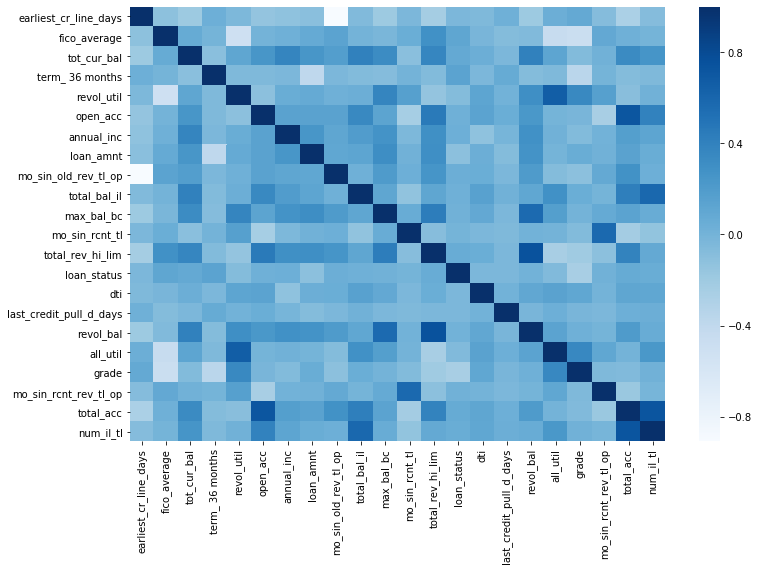

In [0]:
sns.heatmap(X_new_rf.corr(),cmap='Blues',annot=False) 

In [0]:
clean_data1 = pd.DataFrame(X_new_l1)

In [0]:
clean_data1.shape

(121570, 18)

In [0]:
clean_data1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,20332,1,737,1,11,3,90,7,2,95.2,5,1,14.1,546,64,0,10,21
1,13787,1,797,0,6,3,365,1,1,100,0,1,45.17,638,24,1,0,9
2,20878,2,697,3,13,2,132,4,6,89.7,1,1,20.25,638,90,1,1,29
3,21092,1,702,0,6,1,48,4,3,100,7,1,12.87,638,94,1,7,26
4,19052,1,722,1,12,4,184,0,3,96.7,2,1,30.76,485,41,1,2,30


In [0]:
from google.colab import files

X_new_rf.to_csv('clean_X.csv')
files.download('clean_X.csv')

MessageError: ignored

In [0]:
y.shape

In [0]:
y.head()

In [0]:
y.to_csv('clean_y.csv')
files.download('clean_y.csv')